>### Mask-RCNN

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import glob

# Plotting
import imageio
import PIL
from PIL import ImageDraw, Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
import torch.nn.functional as F

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils  import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

#### Data

Refer to [Object Detection API](#object_detection_api):

In [56]:
TEST_IMAGES = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  'Street' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg'
}

<Figure size 864x432 with 0 Axes>

Image has been downloaded to /var/folders/sd/6d0w7lz121v38498dngh6y540000gn/T/tmpo8mo639x.jpg
(856, 1280, 3)


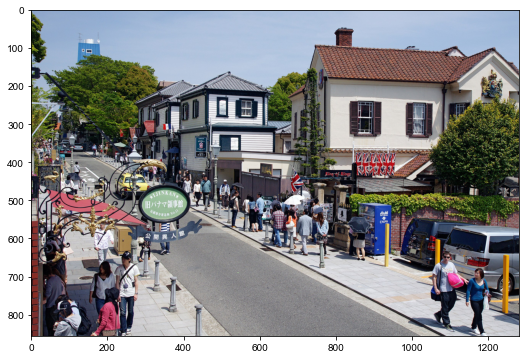

In [61]:
image_url = TEST_IMAGES['Street']
plt.figure(figsize=(12,6))
filepath, image = download_image(image_url, 1280, 856)
image = image_to_numpy(filepath)
print(image.shape)

In [56]:
#导入pbtxt文档记录，得到1-90 classes
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

#### Model
Mask-RCNN architecture with pre-trained [COCO2017](https://cocodataset.org/) weights.

In [73]:
MODULE_HANDLE = "https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1"
model = hub.load(MODULE_HANDLE) #加载模型

In [75]:
# 模型的可选signatures，这里只有默认一种
print(model)
print(model.signatures.keys())

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f11c0630390>
KeysView(_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(input_tensor) at 0x7F11C7562990>}))


In [76]:
#这里可以用detector或者model都行
detector = model.signatures['serving_default'] 
detector

<ConcreteFunction signature_wrapper(input_tensor) at 0x7F11C7562990>

In [111]:
print(len(detector.inputs))
print(detector.inputs[0])
print(len(detector.outputs))
print(detector.outputs[0])
print(detector.graph)
print(len(detector.trainable_variables)) #已经载入weights元祖
print(detector.trainable_variables[0].shape) 
print(detector.variables[0].shape)

1122
Tensor("input_tensor:0", shape=(1, None, None, 3), dtype=uint8)
23
Tensor("Identity:0", shape=(None, 4), dtype=float32)
FuncGraph(name=signature_wrapper, id=139714334147920)
506
(3, 3, 3, 32)
(3, 3, 3, 32)


#### Prediction

In [86]:
converted_image  = image[np.newaxis, ...] #model只需要转变numpy数据维度(h,w,c)->(m,h,w,c)
converted_image  = tf.convert_to_tensor(image[np.newaxis, ...]) #detector需要tensor
y_pred = detector(converted_image) #输出字典，包括检测到的objects分数、label和bboxes
y_pred = {key:value.numpy() for key,value in y_pred.items()} #把tensor转为numpy数组
y_pred.keys()

dict_keys(['detection_anchor_indices', 'num_detections', 'rpn_features_to_crop', 'refined_box_encodings', 'raw_detection_scores', 'num_proposals', 'final_anchors', 'detection_classes', 'detection_scores', 'image_shape', 'proposal_boxes', 'detection_multiclass_scores', 'rpn_box_encodings', 'rpn_box_predictor_features', 'detection_masks', 'rpn_objectness_predictions_with_background', 'anchors', 'detection_boxes', 'class_predictions_with_background', 'mask_predictions', 'raw_detection_boxes', 'box_classifier_features', 'proposal_boxes_normalized'])

In [112]:
#预测结构都是列表{'key':[array, array]}，查看每张图片会得到的值shape
print(f'There are {len(y_pred.keys())} outputs, and can predict {len(y_pred["detection_scores"][0])} objects.')
for i in sorted(y_pred.keys()):
    print(f'{i}: {y_pred[i].shape}')

There are 23 outputs, and can predict 100 objects.
anchors: (49152, 4)
box_classifier_features: (300, 9, 9, 1536)
class_predictions_with_background: (300, 91)
detection_anchor_indices: (1, 100)
detection_boxes: (1, 100, 4)
detection_classes: (1, 100)
detection_masks: (1, 100, 33, 33)
detection_multiclass_scores: (1, 100, 91)
detection_scores: (1, 100)
final_anchors: (1, 300, 4)
image_shape: (4,)
mask_predictions: (100, 90, 33, 33)
num_detections: (1,)
num_proposals: (1,)
proposal_boxes: (1, 300, 4)
proposal_boxes_normalized: (1, 300, 4)
raw_detection_boxes: (1, 300, 4)
raw_detection_scores: (1, 300, 91)
refined_box_encodings: (300, 90, 4)
rpn_box_encodings: (1, 49152, 4)
rpn_box_predictor_features: (1, 64, 64, 512)
rpn_features_to_crop: (1, 64, 64, 1088)
rpn_objectness_predictions_with_background: (1, 49152, 2)


#### Visualize

In [107]:
def object_detection_api(image, detector, label_id_offset=0):
    converted_image  = image[np.newaxis, ...] 
    y_pred = model(converted_image)
    y_pred = {key:value.numpy() for key,value in y_pred.items()} 
    
    boxes = y_pred['detection_boxes'][0]
    detection_boxes = tf.convert_to_tensor(y_pred['detection_boxes'][0])
    labels = (y_pred['detection_classes'][0] + label_id_offset).astype(int)
    scores = y_pred['detection_scores'][0]
    detection_masks = tf.convert_to_tensor(y_pred['detection_masks'][0])
    
    # reframe the the bounding box mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8) #筛选
    y_pred['detection_masks_reframed'] = detection_masks_reframed.numpy()
    

    # 画图
    plt.figure(figsize=(12,12))
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image, boxes, labels, scores, category_index, min_score_thresh=.70,
        use_normalized_coordinates=True, max_boxes_to_draw=100, agnostic_mode=False,
        instance_masks = y_pred['detection_masks_reframed'])
    plt.imshow(image)
    plt.axis('off')

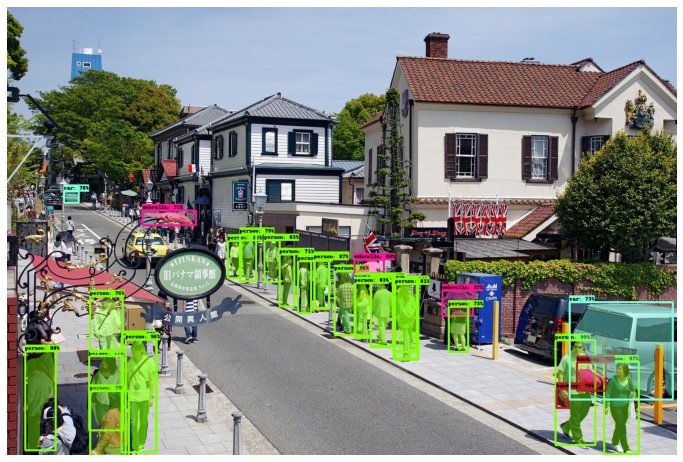

In [108]:
object_detection_api(image, detector, label_id_offset=0)